# Implementing backpropagation manually

## Setup

In [3]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open("names.txt").read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [5]:
# Build vocabulary and mappings
chars = sorted(list(set("".join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0

i_to_s = {i: s for s, i in s_to_i.items()}

vocab_size = len(s_to_i)

In [6]:
CONTEXT_LENGTH = 3  # Block size: number of previous characters to consider when predicting the next character


def build_dataset(words, label):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * CONTEXT_LENGTH

        for char in word + ".":
            ix = s_to_i[char]
            X.append(context)
            Y.append(ix)

            # print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
            context = context[1:] + [ix]

        # print("=" * 10)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(label, X.shape, Y.shape)
    return X, Y

In [7]:
random.seed(42)

# Shuffle the words in the dataset
random.shuffle(words)

# Split the dataset into train, validation and test sets
train_index = int(0.8 * len(words))
val_index = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:train_index], "train")
X_val, Y_val = build_dataset(words[train_index:val_index], "validation")
X_test, Y_test = build_dataset(words[val_index:], "test")

train torch.Size([182625, 3]) torch.Size([182625])
validation torch.Size([22655, 3]) torch.Size([22655])
test torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# Compare manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:10s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff:.5f}')

In [9]:
n_embed = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(vocab_size, n_embed), generator=g)

# Layer 1
W1 = torch.randn(size=(n_embed * CONTEXT_LENGTH, n_hidden), generator=g) * (
    (5 / 3) / (n_embed * CONTEXT_LENGTH**0.5)
)
b1 = torch.randn(size=(n_hidden,), generator=g) * 0.1

# Layer 2
W2 = torch.randn(size=(n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(size=(vocab_size,), generator=g) * 0.1

# Batch normalization
bngain = torch.randn(size=(1, n_hidden), generator=g) * 0.1 + 1.0
bnbias = torch.randn(size=(1, n_hidden), generator=g) * 0.1

params = [C, W1, b1, W2, b2, bngain, bnbias]

for p in params:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 4137


In [10]:
# Create a single training batch
batch_size = 32

batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

## Exercise 1: backprop through everything manually

In [11]:
# 1 step of training (forward pass)
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], -1)

# Linear layer 1
hprebn = emb_cat @ W1 + b1

# BatchNorm layer
bnmean = (1 / batch_size) * hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmean
bndiff_sq = bndiff**2
bnvar = (1 / (batch_size - 1)) * bndiff_sq.sum(dim=0, keepdim=True)
bnstd_inv = (bnvar + 1e-5) ** -0.5

bnraw = bndiff * bnstd_inv
hpreact = bngain * bnraw + bnbias

# Activation layer
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# Cross-entropy loss
logits_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv

logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

# PyTorch backward pass
for p in params:
    p.grad = None

for t in [
    logprobs,
    probs,
    counts_sum_inv,
    counts_sum,
    counts,
    norm_logits,
    logits_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnstd_inv,
    bnvar,
    bndiff_sq,
    bndiff,
    bnmean,
    bngain,
    bnbias,
    hprebn,
    emb_cat,
    emb,
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3285, grad_fn=<NegBackward0>)

#### `logprobs`
$$
\begin{align*}
\text{Let } l_{i} &= \log p(y_i | x_i) \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\
\frac{\partial \mathcal{L}}{\partial l_{i}} &= -1
\end{align*}
$$

For indexes $\neq i$, the derivative is $0$ as these log probabilities do not contribute to $\mathcal{L}$


In [12]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0 / batch_size
cmp('logprobs', dlogprobs, logprobs)

logprobs   | exact: True  | approx: True  | maxdiff: 0.00000


#### `probs`
$$
\begin{align*}
\text{Let } p_{i} &= p(y_i | x_i) \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial p_{i}} &= \frac{\partial \mathcal{L}}{\partial l_{i}} \frac{\partial l_{i}}{\partial p_{i}} \\
\frac{\partial l_{i}}{\partial p_{i}} &= \frac{1}{p_{i}} \\
\frac{\partial \mathcal{L}}{\partial p_{i}} &= -\frac{1}{p_{i}} \\

\end{align*}
$$

In [13]:
dprobs = dlogprobs * (1 / probs)
cmp('probs', dprobs, probs)

probs      | exact: True  | approx: True  | maxdiff: 0.00000


#### `counts_sum_inv`

$$
\begin{align*}
\text{Let } CSI_{i} &= (\frac{1}{\sum_{j=1}^{27} c_{j}}) \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial CSI_{i}} &= \frac{\partial \mathcal{L}}{\partial p_{i}} \frac{\partial p_{i}}{\partial CSI_{i}} \\

\frac{\partial p_{i}}{\partial CSI_{i}} &= c_{i} \\

\end{align*}
$$


In [14]:
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv | exact: True  | approx: True  | maxdiff: 0.00000


#### `counts_sum`

$$
\begin{align*}
\text{Let } CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial CS_{i}} &= \frac{\partial \mathcal{L}}{\partial CSI_{i}}\frac{\partial CSI_{i}}{\partial CS_{i}} \\
\frac{\partial CSI_{i}}{\partial CS_{i}} &= -\frac{1}{CS_{i}^2} \\

\end{align*}
$$


In [15]:
dcounts_sum = (-1.0 * (counts_sum ** -2)) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum | exact: True  | approx: True  | maxdiff: 0.00000


#### `counts`

$$
\begin{align*}
\text{Let } c_{i} &= e^{NL_{i}} \\
CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial c_{i}} &= \frac{\partial \mathcal{L}}{\partial p_{i}} \frac{\partial p_{i}}{\partial c_{i}} \\

\frac{\partial p_{i}}{\partial c_{i}} &= CSI_{i} + \frac{\partial CSI_{i}}{\partial c_{i}} \\
\frac{\partial CSI_{i}}{\partial c_{i}} &= -\frac{1}{CS_{i}^2} \frac{\partial CS_{i}}{\partial c_{i}} \\

\frac{\partial CS_{i}}{\partial c_{i}} &= 1 \\

\end{align*}
$$


In [16]:
dcounts = (counts_sum_inv * dprobs) + torch.ones_like(counts) * dcounts_sum
cmp("counts", dcounts, counts)

counts     | exact: True  | approx: True  | maxdiff: 0.00000


#### `norm_logits`

$$
\begin{align*}
\text{Let } NL_{i} &= L_{i} - \max_{j} L_{j} \\
c_{i} &= e^{NL_{i}} \\
CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\


\\

\frac{\partial \mathcal{L}}{\partial NL_{i}} &= \frac{\partial \mathcal{L}}{\partial c_{i}} \frac{\partial c_{i}}{\partial NL_{i}} \\
\frac{\partial c_{i}}{\partial NL_{i}} &= e^{NL_{i}} \\

\end{align*}
$$


In [17]:
dnorm_logits = counts * dcounts
cmp("norm_logits", dnorm_logits, norm_logits)

norm_logits | exact: True  | approx: True  | maxdiff: 0.00000


#### `logits_maxes`

$$
\begin{align*}
\text{Let } LM_{i} &= \max_{j} L_{j} \\
NL_{i} &= L_{i} - LM_{i} \\
c_{i} &= e^{NL_{i}} \\
CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\


\\

\frac{\partial \mathcal{L}}{\partial LM_{i}} &= \frac{\partial \mathcal{L}}{\partial NL_{i}} \frac{\partial NL_{i}}{\partial LM_{i}} \\

\frac{\partial NL_{i}}{\partial LM_{i}} &= -1 \\

\end{align*}
$$


In [18]:
dlogits_maxes = (-1.0 * torch.ones_like(logits_maxes)) * dnorm_logits.sum(dim=1, keepdim=True)
cmp("logits_maxes", dlogits_maxes, logits_maxes)

logits_maxes | exact: True  | approx: True  | maxdiff: 0.00000


#### `logits`

$$
\begin{align*}
\text{Let } L_{i} &= h \times W_{i} + b_{i} \\
LM_{i} &= \max_{j} L_{j} \\
NL_{i} &= L_{i} - LM_{i} \\
c_{i} &= e^{NL_{i}} \\
CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\


\\

\frac{\partial \mathcal{L}}{\partial L_{i}} &= \frac{\partial \mathcal{L}}{\partial NL_{i}} \frac{\partial NL_{i}}{\partial L_{i}} \\
\frac{\partial NL_{i}}{\partial L_{i}} &= 1  + \frac{\partial NL_{i}}{\partial LM_{i}} \frac{\partial LM_{i}}{\partial L_{i}} \\
\frac{\partial LM_{i}}{\partial L_{i}} &= \begin{cases}
1 & \text{if } L_{i} = LM_{i} \\
0 & \text{otherwise}
\end{cases} \\


\end{align*}
$$


In [19]:
dlogits = dnorm_logits.clone() + F.one_hot(logits.max(dim=1).indices, logits.shape[1]) * dlogits_maxes
cmp("logits", dlogits, logits)

logits     | exact: True  | approx: True  | maxdiff: 0.00000


#### `h`

$$
\begin{align*}
\text{Let } h &= \tanh(hpreact) \\
L &= h \times W_2 + b_2 \\
LM_{i} &= \max_{j} L_{j} \\
NL_{i} &= L_{i} - LM_{i} \\
c_{i} &= e^{NL_{i}} \\
CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\
\end{align*}
$$


$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial h} &= \frac{\partial \mathcal{L}}{\partial L} \frac{\partial L}{\partial h} \\
\\
h \times W_2 &=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & a_{14} \\
a_{21} & a_{22} & a_{23} & a_{24} \\
a_{31} & a_{32} & a_{33} & a_{34} \\
\end{bmatrix} \times \begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\
b_{31} & b_{32} \\
b_{41} & b_{42} \\
\end{bmatrix} \\
\begin{bmatrix}
d_{11} & d_{12} \\
d_{21} & d_{22} \\
d_{31} & d_{32} \\
\end{bmatrix}
&= \begin{bmatrix}
a_{11}b_{11} + a_{12}b_{21} + a_{13}b_{31} + a_{14}b_{41} & a_{11}b_{12} + a_{12}b_{22} + a_{13}b_{32} + a_{14}b_{42} \\
a_{21}b_{11} + a_{22}b_{21} + a_{23}b_{31} + a_{24}b_{41} & a_{21}b_{12} + a_{22}b_{22} + a_{23}b_{32} + a_{24}b_{42} \\
a_{31}b_{11} + a_{32}b_{21} + a_{33}b_{31} + a_{34}b_{41} & a_{31}b_{12} + a_{32}b_{22} + a_{33}b_{32} + a_{34}b_{42} \\
\end{bmatrix}

\\
\\

\frac{\partial \mathcal{L}}{\partial {a_{11}}} &= \frac{\partial \mathcal{L}}{\partial {d_{11}}} \frac{\partial {d_{11}}}{\partial {a_{11}}} + \frac{\partial \mathcal{L}}{\partial {d_{12}}} \frac{\partial {d_{12}}}{\partial {a_{11}}}
\\
\vdots
\\
\frac{\partial \mathcal{L}}{\partial {a_{34}}} &= \frac{\partial \mathcal{L}}{\partial {d_{31}}} \frac{\partial {d_{31}}}{\partial {a_{34}}} + \frac{\partial \mathcal{L}}{\partial {d_{32}}} \frac{\partial {d_{32}}}{\partial {a_{34}}}

\\
\frac{\partial \mathcal{L}}{\partial h} &= \begin{bmatrix}
\frac{\partial \mathcal{L}}{\partial {d_{11}}} & \frac{\partial \mathcal{L}}{\partial {d_{12}}} \\
\frac{\partial \mathcal{L}}{\partial {d_{21}}} & \frac{\partial \mathcal{L}}{\partial {d_{22}}} \\
\frac{\partial \mathcal{L}}{\partial {d_{31}}} & \frac{\partial \mathcal{L}}{\partial {d_{32}}} \\
\end{bmatrix} \times \begin{bmatrix}
b_{11} & b_{21} & b_{31} & b_{41} \\
b_{12} & b_{22} & b_{32} & b_{42} \\
\end{bmatrix} \\ &= \frac{\partial \mathcal{L}}{\partial d} \times W_2^T \\
\frac{\partial \mathcal{L}}{\partial h} &= \frac{\partial \mathcal{L}}{\partial L} \times W_2^T
\end{align*}
$$



In [20]:
dh = dlogits @ W2.T
cmp("h", dh, h)

h          | exact: True  | approx: True  | maxdiff: 0.00000


#### `W_2`

$$
\begin{align*}
h &= \tanh(hpreact) \\
L &= h \times W_2 + b_2 \\
LM_{i} &= \max_{j} L_{j} \\
NL_{i} &= L_{i} - LM_{i} \\
c_{i} &= e^{NL_{i}} \\
CS_{i} &= \sum_{j=1}^{27} c_{j} \\
CSI_{i} &= \frac{1}{CS_{i}} \\
p_{i} &= {c_{i}} * {CSI_{i}} \\
l_{i} &= \log p_{i} \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\frac{\partial \mathcal{L}}{\partial W_2} &= h^T \times \frac{\partial \mathcal{L}}{\partial L} \\

\end{align*}
$$



In [21]:
dW_2 = h.T @ dlogits
cmp("W2", dW_2, W2)

W2         | exact: True  | approx: True  | maxdiff: 0.00000


#### `b_2`

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial b_2} &= \frac{\partial \mathcal{L}}{\partial L} \frac{\partial L}{\partial b_2} \\
\frac{\partial L}{\partial b_2} &= 1 \\
\end{align*}
$$



In [22]:
db_2 = dlogits.sum(dim=0)
cmp("b2", db_2, b2)

b2         | exact: True  | approx: True  | maxdiff: 0.00000


#### `hpreact`

$$
\begin{align*}
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial hpreact} &= \frac{\partial \mathcal{L}}{\partial h} \frac{\partial h}{\partial hpreact} \\
\frac{\partial h}{\partial hpreact} &= 1 - \tanh^2(hpreact) \\

\end{align*}


$$


In [23]:
dhpreact = (1 - h**2) * dh
cmp("hpreact", dhpreact, hpreact)

hpreact    | exact: True  | approx: True  | maxdiff: 0.00000


#### `bngain`

$$
\begin{align*}

hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \gamma} &= \frac{\partial \mathcal{L}}{\partial hpreact} \frac{\partial hpreact}{\partial \gamma} \\
\frac{\partial hpreact}{\partial \gamma} &= BN_{raw} \\

\end{align*}


$$


In [24]:
dbngain = (dhpreact * bnraw).sum(dim=0)
cmp("bngain", dbngain, bngain)

bngain     | exact: True  | approx: True  | maxdiff: 0.00000


#### `bnbias`

$$
\begin{align*}

hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \beta} &= \frac{\partial \mathcal{L}}{\partial hpreact} \frac{\partial hpreact}{\partial \beta} \\
\frac{\partial hpreact}{\partial \beta} &= 1 \\

\end{align*}


$$


In [25]:
dbnbias = dhpreact.sum(dim=0)
cmp("bnbias", dbnbias, bnbias)

bnbias     | exact: True  | approx: True  | maxdiff: 0.00000


#### `bnraw`

$$
\begin{align*}

hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial BN_{raw}} &= \frac{\partial \mathcal{L}}{\partial hpreact} \frac{\partial hpreact}{\partial BN_{raw}} \\
\frac{\partial hpreact}{\partial BN_{raw}} &= \gamma \\

\end{align*}


$$


In [26]:
dbnraw = bngain * dhpreact
cmp("bnraw", dbnraw, bnraw)

bnraw      | exact: True  | approx: True  | maxdiff: 0.00000


#### `bnstd_inv`

$$
\begin{align*}
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \sigma_{BN}} &= \frac{\partial \mathcal{L}}{\partial BN_{raw}} \frac{\partial BN_{raw}}{\partial \sigma_{BN}} \\
\frac{\partial BN_{raw}}{\partial \sigma_{BN}} &= \delta_{BN} \\

\end{align*}


$$


In [27]:
dbnstd_inv = (dbnraw * bndiff).sum(dim=0)
cmp("bnstd_inv", dbnstd_inv, bnstd_inv)

bnstd_inv  | exact: True  | approx: True  | maxdiff: 0.00000


#### `bnvar`

$$
\begin{align*}
\sigma^2_{BN} &= \frac{1}{N-1} \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \sigma^2_{BN}} &= \frac{\partial \mathcal{L}}{\partial \sigma_{BN}} \frac{\partial \sigma_{BN}}{\partial \sigma^2_{BN}} \\
\frac{\partial \sigma_{BN}}{\partial \sigma^2_{BN}} &= -0.5 \frac{1}{(\sigma^2_{BN} + \epsilon)^{1.5}} \\

\end{align*}


$$


In [28]:
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnstd_inv
cmp("bnvar", dbnvar, bnvar)

bnvar      | exact: True  | approx: True  | maxdiff: 0.00000


#### `bndiff_sq`

$$
\begin{align*}
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \delta^2_{BN}} &= \frac{\partial \mathcal{L}}{\partial \sigma^2_{BN}} \frac{\partial \sigma^2_{BN}}{\partial \delta^2_{BN}} \\

\frac{\partial \sigma^2_{BN}}{\partial \delta^2_{BN}} &= \frac{1}{N-1} \\


\end{align*}


$$


In [29]:
dbndiff_sq = (1 / (batch_size - 1)) * torch.ones_like(bndiff_sq) * dbnvar
cmp("bndiff_sq", dbndiff_sq, bndiff_sq)

bndiff_sq  | exact: True  | approx: True  | maxdiff: 0.00000


#### `bndiff`

$$
\begin{align*}
\delta_{BN} &= hprebn - \mu_{BN} \\
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \delta_{BN}} &= \frac{\partial \mathcal{L}}{\partial BN_{raw}} \frac{\partial BN_{raw}}{\partial \delta_{BN}} + \frac{\partial \mathcal{L}}{\partial \delta^2_{BN}} \frac{\partial \delta^2_{BN}}{\partial \delta_{BN}} \\


\frac{\partial BN_{raw}}{\partial \delta_{BN}} &= \sigma_{BN} \\

\frac{\partial \delta^2_{BN}}{\partial \delta_{BN}} &= 2 \delta_{BN} \\

\end{align*}


$$


In [30]:
dbndiff = ((2 * bndiff) * dbndiff_sq) + (dbnraw * bnstd_inv)
cmp("bndiff", dbndiff, bndiff)

bndiff     | exact: True  | approx: True  | maxdiff: 0.00000


#### `bnmean`

$$
\begin{align*}
\mu_{BN} &= \frac{1}{N} \sum hprebn \\
\delta_{BN} &= hprebn - \mu_{BN} \\
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial \mu_{BN}} &= \frac{\partial \mathcal{L}}{\partial \delta_{BN}} \frac{\partial \delta_{BN}}{\partial \mu_{BN}} \\

\frac{\partial \delta_{BN}}{\partial \mu_{BN}} &= -1 \\

\end{align*}


$$


In [31]:
dbnmean = (-torch.ones_like(bndiff) * dbndiff).sum(0)
cmp("bnmean", dbnmean, bnmean)

bnmean     | exact: True  | approx: True  | maxdiff: 0.00000


#### `hprebn`

$$
\begin{align*}
hprebn &= emb_c \times W_1 + b_1 \\
\mu_{BN} &= \frac{1}{N} \sum hprebn \\
\delta_{BN} &= hprebn - \mu_{BN} \\
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\frac{\partial \mathcal{L}}{\partial hprebn} &= \frac{\partial \mathcal{L}}{\partial \delta_{BN}} \frac{\partial \delta_{BN}}{\partial hprebn} + \frac{\partial \mathcal{L}}{\partial \mu_{BN}} \frac{\partial \mu_{BN}}{\partial hprebn} \\
\end{align*}


$$


In [32]:
dhprebn = dbndiff.clone() + ((1.0 / batch_size) * torch.ones_like(hprebn) * dbnmean)
cmp("hprebn", dhprebn, hprebn)

hprebn     | exact: True  | approx: True  | maxdiff: 0.00000


#### `W_1`

$$
\begin{align*}
hprebn &= emb_c \times W_1 + b_1 \\
\mu_{BN} &= \frac{1}{N} \sum hprebn \\
\delta_{BN} &= hprebn - \mu_{BN} \\
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\\

\frac{\partial \mathcal{L}}{\partial W_1} &= \frac{\partial \mathcal{L}}{\partial hprebn} \frac{\partial hprebn}{\partial W_1} \\
\frac{\partial hprebn}{\partial W_1} &= emb_c^T \\

\end{align*}


$$


In [33]:
dW_1 = emb_cat.T @ dhprebn
cmp("W1", dW_1, W1)

W1         | exact: True  | approx: True  | maxdiff: 0.00000


#### `b_1`

$$
\begin{align*}
hprebn &= emb_c \times W_1 + b_1 \\
\mu_{BN} &= \frac{1}{N} \sum hprebn \\
\delta_{BN} &= hprebn - \mu_{BN} \\
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\\

\frac{\partial \mathcal{L}}{\partial b_1} &= \frac{\partial \mathcal{L}}{\partial hprebn} \frac{\partial hprebn}{\partial b_1} \\
\frac{\partial hprebn}{\partial b_1} &= 1 \\

\end{align*}


$$


In [34]:
db_1 = dhprebn.sum(dim=0)
cmp("b1", db_1, b1)

b1         | exact: True  | approx: True  | maxdiff: 0.00000


#### `emb_cat`

$$
\begin{align*}
hprebn &= emb_c \times W_1 + b_1 \\
\mu_{BN} &= \frac{1}{N} \sum hprebn \\
\delta_{BN} &= hprebn - \mu_{BN} \\
\sigma^2_{BN} &= \frac{1}{N-1} \sum \delta^2_{BN} \\
\sigma_{BN} &= \frac{1}{\sqrt{\sigma^2_{BN} + \epsilon}} \\
BN_{raw} &= {\delta_{BN}} * {\sigma_{BN}} \\
hpreact &= \gamma * BN_{raw} + \beta \\
h &= \tanh(hpreact) \\
\vdots \\
\mathcal{L} &= -\frac{1}{N}\sum_{i=1}^N l_{i} \\

\\

\\

\frac{\partial \mathcal{L}}{\partial emb_c} &= \frac{\partial \mathcal{L}}{\partial hprebn} \frac{\partial hprebn}{\partial emb_c} \\
\frac{\partial hprebn}{\partial emb_c} &= W_1^T \\

\end{align*}


$$


In [35]:
demb_cat = dhprebn @ W1.T
cmp("emb_cat", demb_cat, emb_cat)

emb_cat    | exact: True  | approx: True  | maxdiff: 0.00000


#### `emb`

Change the view of `emb_cat` to the shape of `emb`

In [36]:
demb = demb_cat.view(emb.shape)
cmp("emb", demb, emb)

emb        | exact: True  | approx: True  | maxdiff: 0.00000


#### `C`

Index the `demb` Tensor using the original indexes

In [37]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp("C", dC, C)

C          | exact: True  | approx: True  | maxdiff: 0.00000


In [38]:
# Check all backpropagations
cmp("C", dC, C)
cmp("W1", dW_1, W1)
cmp("b1", db_1, b1)
cmp("W2", dW_2, W2)
cmp("b2", db_2, b2)
cmp("bngain", dbngain, bngain)
cmp("bnbias", dbnbias, bnbias)
cmp("hprebn", dhprebn, hprebn)
cmp("emb_cat", demb_cat, emb_cat)
cmp("emb", demb, emb)
cmp("hpreact", dhpreact, hpreact)
cmp("bnraw", dbnraw, bnraw)
cmp("bnstd_inv", dbnstd_inv, bnstd_inv)
cmp("bnvar", dbnvar, bnvar)
cmp("bndiff_sq", dbndiff_sq, bndiff_sq)
cmp("bndiff", dbndiff, bndiff)
cmp("bnmean", dbnmean, bnmean)
cmp("h", dh, h)
cmp("logits", dlogits, logits)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("counts", dcounts, counts)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("probs", dprobs, probs)
cmp("logprobs", dlogprobs, logprobs)

C          | exact: True  | approx: True  | maxdiff: 0.00000
W1         | exact: True  | approx: True  | maxdiff: 0.00000
b1         | exact: True  | approx: True  | maxdiff: 0.00000
W2         | exact: True  | approx: True  | maxdiff: 0.00000
b2         | exact: True  | approx: True  | maxdiff: 0.00000
bngain     | exact: True  | approx: True  | maxdiff: 0.00000
bnbias     | exact: True  | approx: True  | maxdiff: 0.00000
hprebn     | exact: True  | approx: True  | maxdiff: 0.00000
emb_cat    | exact: True  | approx: True  | maxdiff: 0.00000
emb        | exact: True  | approx: True  | maxdiff: 0.00000
hpreact    | exact: True  | approx: True  | maxdiff: 0.00000
bnraw      | exact: True  | approx: True  | maxdiff: 0.00000
bnstd_inv  | exact: True  | approx: True  | maxdiff: 0.00000
bnvar      | exact: True  | approx: True  | maxdiff: 0.00000
bndiff_sq  | exact: True  | approx: True  | maxdiff: 0.00000
bndiff     | exact: True  | approx: True  | maxdiff: 0.00000
bnmean     | exact: True

## Exercise 2: backprop through cross-entropy

In [55]:
# 1 step of training (forward pass)
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], -1)

# Linear layer 1
hprebn = emb_cat @ W1 + b1

# BatchNorm layer
bnmean = (1 / batch_size) * hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmean
bndiff_sq = bndiff**2
bnvar = (1 / (batch_size - 1)) * bndiff_sq.sum(dim=0, keepdim=True)
bnstd_inv = (bnvar + 1e-5) ** -0.5

bnraw = bndiff * bnstd_inv
hpreact = bngain * bnraw + bnbias

# Activation layer
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# Cross-entropy loss
loss = F.cross_entropy(logits, Yb)

# PyTorch backward pass
for p in params:
    p.grad = None

for t in [
    loss,
    logits,
    h,
    hpreact,
    bnraw,
    bnstd_inv,
    bnvar,
    bndiff_sq,
    bndiff,
    bnmean,
    bngain,
    bnbias,
    hprebn,
    emb_cat,
    emb,
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3285, grad_fn=<NllLossBackward0>)

#### `loss`

$$
\begin{align*}
L &=  -\log p_y  \\
p_{i} &= \frac{e^{l_i}}{\sum_{j=1}^{27} e^{l_j}} \\

\frac{\partial L}{\partial l_i} &= \frac{\partial L}{\partial p_i} \frac{\partial p_i}{\partial l_i} \\
\frac{\partial L}{\partial p_i} &= -\frac{\sum_{j=1}^{27} e^{l_j}}{e^{l_y}} \\

\\

\frac{\partial p_i}{\partial l_i}_{i \neq y} &= \frac{0}{\sum_{j=1}^{27} e^{l_j}} - \frac{e^{l_y} e^{l_i}}{(\sum_{j=1}^{27} e^{l_j})^2} \\
&= \frac{e^{l_y}}{\sum_{j=1}^{27} e^{l_j}} \frac{e^{l_i}}{\sum_{j=1}^{27} e^{l_j}} \\
&= - \frac{1}{\frac{\partial L}{\partial p_i}} p_i \\

\frac{\partial p_i}{\partial l_i}_{i = y} &= \frac{e^{l_y}}{\sum_{j=1}^{27} e^{l_j}} - \frac{e^{l_y} e^{l_i}}{(\sum_{j=1}^{27} e^{l_j})^2} \\ 
&= \frac{e^{l_y}}{\sum_{j=1}^{27} e^{l_j}} (1 - \frac{e^{l_i}}{\sum_{j=1}^{27} e^{l_j}}) \\
&= - \frac{1}{\frac{\partial L}{\partial p_i}} (p_i - 1) \\

\\

\frac{\partial L}{\partial l_i} &= \begin{cases}
p_i - 1 & \text{if } i = y \\
p_i & \text{if } i \neq y
\end{cases} \\

\end{align*}
$$

where $l_{i}$ is the logit for class $i$.


In [50]:
dlogits = F.softmax(logits, dim=1)
dlogits[range(batch_size), Yb] -= 1.0
dlogits /= batch_size

cmp("logits", dlogits, logits)

logits     | exact: False | approx: True  | maxdiff: 0.00000


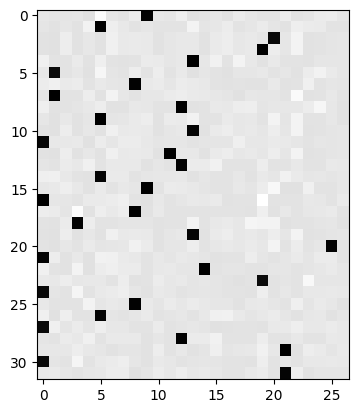

In [51]:
plt.imshow(dlogits.detach().numpy(), cmap="gray")

## Exercise 3: backprop through batchnorm

In [52]:
# 1 step of training (forward pass)
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], -1)

# Linear layer 1
hprebn = emb_cat @ W1 + b1

# BatchNorm layer
hpreact = (
    bngain
    * (hprebn - hprebn.mean(0, keepdim=True))
    / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=False) + 1e-5)
    + bnbias
)

# Activation layer
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# Cross-entropy loss
loss = F.cross_entropy(logits, Yb)

# PyTorch backward pass
for p in params:
    p.grad = None

for t in [
    loss,
    logits,
    h,
    hpreact,
    hprebn,
    emb_cat,
    emb,
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3303, grad_fn=<NllLossBackward0>)

### `hprebn`

$$
\begin{align*}
\text{Let } y_i &= hpreact \\
y_i &= \gamma \hat{x_i} + \beta \\
\hat{x_i} &= \frac{x_i - \mu_{B}}{\sqrt{\sigma^2_{B} + \epsilon}} \\
\mu_{B} &= \frac{1}{N} \sum x_i \\
\sigma^2_{B} &= \frac{1}{N-1} \sum (x_i - \mu_{B})^2 \\

\\

\frac{\partial L}{\partial x_i} &= \frac{\partial L}{\partial \hat{x_i}} \frac{\partial \hat{x_i}}{\partial x_i} + \frac{\partial L}{\partial \mu_{B}} \frac{\partial \mu_{B}}{\partial x_i} + \frac{\partial L}{\partial \sigma^2_{B}} \frac{\partial \sigma^2_{B}}{\partial x_i} \\




\end{align*}
$$

In [56]:
dhprebn = (
    bngain
    * bnstd_inv
    / batch_size
    * (
        batch_size * dhpreact
        - dhpreact.sum(0)
        - batch_size / (batch_size - 1) * bnraw * (dhpreact * bnraw).sum(0)
    )
)

cmp("hprebn", dhprebn, hprebn)

hprebn     | exact: False | approx: True  | maxdiff: 0.00000
